In [2]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import pool
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy as sp
import bottleneck as bt
from scipy.stats import pearsonr
from scipy.cluster import hierarchy

# except: 
import tensortools as tt
from flow.misc import wordhash
from cascade import utils
from cascade import paths
from cascade import tca
from functools import reduce

In [81]:
def _get_fitting_template_defaults(mouse, sigma=3, sec=15.5, normalize=False):
    """
    Helper function for convolving Gaussian kernel with onset, sustained 
    stimulus, stimulus offset, and ensure delivery period. These can then be
    used for simple linear regression or GLM. 
    """

    # preallocate Gaussian kernel convolution 
    gker = []
    
    # dumb params
    blur = 0
    elag = sec/4
    ilag = sec/1.5
    # pick ranges of relevant time periods for convolution
    if mouse in ['OA32', 'OA34', 'OA36']:
        sus_e = np.arange(np.floor(sec + elag), np.round(sec*3 + blur), 1)
        sus_i = np.arange(np.floor(sec + ilag), np.round(sec*3 + ilag + blur), 1)
    else:
        sus_e = np.arange(np.floor(sec + elag), np.round(sec*4 + elag + blur), 1)
        sus_i = np.arange(np.floor(sec + ilag), np.round(sec*4 + ilag + blur), 1)
        
    base = np.ones(108)
    ranges = [sus_e, sus_i]

    # convolve
    for i in ranges:
        i = [int(s) for s in i]
        starter = np.zeros((108))
        starter[i] = 1
        gker.append(sp.ndimage.gaussian_filter1d(starter, sigma, mode='constant', cval=0))
    gker.append(base[None, :])

    # normalize filters
    if normalize:
        gker = [(s - np.min(s))/np.max(s) for s in gker]
    gker[1] *= -1
    
    templates = np.vstack(gker).T

    return templates

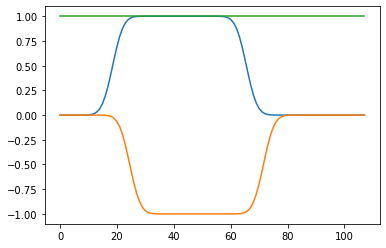

In [82]:
plt.plot(_get_fitting_template_defaults('OA27'))

In [29]:
model, ids, tensor, meta, bhv, sorts = cas.load.load_all_groupday(
        mouse='OA27',
        trace_type='zscore_day_bump_trunc',
        method='ncp_hals',
        cs='',
        warp=False,
        word='charts',
        rank=10,
        group_by='l_vs_r1_tight',
        nan_thresh=0.95,
        score_threshold=0.8,
        full_output=False,
        unsorted=True,
        with_model=True,
        verbose=True)

OA27: charts: Re-balancing factors.
OA27: charts: Re-nonneg-ing cell factors.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


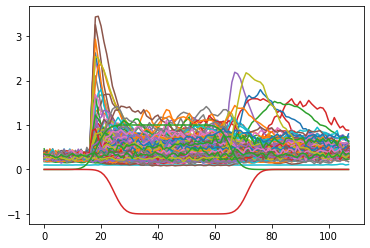

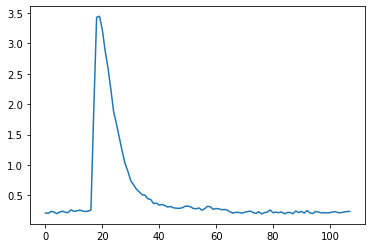

In [55]:
plt.plot(np.nanmean(tensor[:, :, :400], axis=2).T);
plt.plot(_get_fitting_template_defaults('OA27'))
means = np.nanmean(tensor[:, :, :400], axis=2)
plt.figure(0)
plt.plot(means[55, :].T);

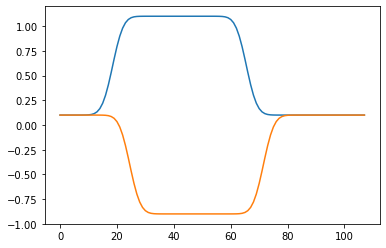

In [62]:
plt.plot(_get_fitting_template_defaults('OA27') + 0.1)

In [105]:
np.any(np.isnan(b))

True

In [116]:
test_list = []

A = _get_fitting_template_defaults('OA27')
for cell in range(tensor.shape[0]):
    
    means1 = np.nanmean(tensor[:, :, :401], axis=2)
    means2 = np.nanmean(tensor[:, :, 401:], axis=2)
    if np.any(np.isnan(means1[cell, :])) or np.any(np.isnan(means2[cell, :])):
        continue
        
    fig, ax = plt.subplots(2,5, figsize=(20, 5), sharey=True, sharex=True)
    for c, cs in enumerate(meta['initial_condition'].unique()):
        cs_boo = meta['initial_condition'].isin([cs])[:401]
        means = np.nanmean(tensor[:, :, :401][:, :, cs_boo], axis=2)
        
        b = means[cell, :]
        test = sp.optimize.nnls(A[:60,:], b[:60])[0]
        test_list.append(test)
        
        ax[0, c].plot(means[cell, :].T, color=cas.lookups.color_dict[cs]);
        ax[0, c].plot(test[0]*A[:, 0] + test[1]*A[:, 1] + test[2]*A[:, 2])
        ax[0, c].set_title(f'initial {cs}\n{[round(s, 3) for s in test]}');

        ax[0, -1].plot(means[cell, :].T, color=cas.lookups.color_dict[cs]);
        ax[0, -1].set_title('overlay');
        ax[0, -2].plot(test[0]*A[:, 0] + test[1]*A[:, 1] + test[2]*A[:, 2], color=cas.lookups.color_dict[cs])
        ax[0, -2].set_title('overlay model');
        
    for c, cs in enumerate(meta['initial_condition'].unique()):
        cs_boo = meta['initial_condition'].isin([cs])[401:]
        means = np.nanmean(tensor[:, :, 401:][:, :, cs_boo], axis=2)
        
        b = means[cell, :]
        test = sp.optimize.nnls(A[:60,:], b[:60])[0]
        test_list.append(test)
        
        ax[1, c].plot(means[cell, :].T, color=cas.lookups.color_dict[cs]);
        ax[1, c].plot(test[0]*A[:, 0] + test[1]*A[:, 1] + test[2]*A[:, 2])
        ax[1, c].set_title([round(s, 3) for s in test]);

        ax[1, -1].plot(means[cell, :].T, color=cas.lookups.color_dict[cs]);
#         ax[1, -1].set_title('overlay');
        ax[1, -2].plot(test[0]*A[:, 0] + test[1]*A[:, 1] + test[2]*A[:, 2], color=cas.lookups.color_dict[cs])
#         ax[1, -2].set_title('overlay model');
    ax[1, 0].set_ylabel('reversal')
    ax[0, 0].set_ylabel('learning')
    plt.suptitle(f'cell {cell} mean response across reversal: E vs I NNLS model', y=1.10)                  
    plt.savefig(os.path.join('simple_inhib_NNLS', f'cell{cell}_e_vs_i.png'), bbox_inches='tight')
    plt.close('all')
    

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\Anaconda3\lib\site-packages\ip

In [107]:
b

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [ ]:
fits_control = {}
daily_avg_dict_control = {}
oris = [0, 135, 270]
# A = np.vstack(norm_gker).T
for mi, proj, meti in zip(mice, thresh_list_control, meta_list):
    
    meti = _update_meta_date_vec(meti)
    meti = _update_meta_stages(meti)
    A = _get_fitting_template_defaults(mi)
    all_ori = meti['orientation'].values
    all_days = meti.reset_index()['parsed_stage'].values
    u_days = meti.reset_index()['parsed_stage'].unique()
    firsty = _first100_wtrans_bool(meti)
    
    eng_boo = meti['hmm_engaged'].values
    
    daily_avg_dict_control[mi] = {}
    fits_control[mi] = {}
    
    for c, comp_n in enumerate(proj.keys()):
        fits_control[mi][comp_n] = {}
        daily_avg_dict_control[mi][comp_n] = {}
        for ori in oris:
            cell_mat = np.zeros((proj[comp_n].shape[0], proj[comp_n].shape[1], len(u_days)))
            for dc, day_i in enumerate(u_days):
                day_ori_bool = (all_ori == ori) & (all_days == day_i) & firsty
                for c_n in range(cell_mat.shape[0]):
                    driven_boo = simp_comp_proj_list[mi][comp_n][c_n, :] > 0
                    if np.sum(driven_boo & day_ori_bool) > 0:
                        cell_mat[c_n, :, dc] = np.nanmean(proj[comp_n][c_n, :, driven_boo & day_ori_bool & eng_boo], axis=0)
            all_tr = np.zeros((proj[comp_n].shape[0], A.shape[1], len(u_days)))
            for tr_n in range(cell_mat.shape[2]):
                for c_n in range(cell_mat.shape[0]):
                    b = deepcopy(cell_mat[c_n, :, tr_n])
                    b[b < 0] = 0
                    if np.sum(np.isnan(b)) == len(b):
                        sp_ans = np.zeros(4)
                        sp_ans[:] = np.nan
                        sp_ans = sp_ans
                    else:
                        sp_ans = sp.optimize.nnls(A, b)[0]
                    all_tr[c_n, :, tr_n] = sp_ans
            fits_control[mi][comp_n]['ori_{}'.format(ori)] = all_tr
            fits_control[mi][comp_n]['trial_inds_{}'.format(ori)] = np.where(all_ori == ori)[0]
            daily_avg_dict_control[mi][comp_n]['ori_{}'.format(ori)] = cell_mat

    print('Making progress: {} done.'.format(mi))